<h1><font size="+4"><center>
    Casos prácticos de modelado <br/>
    mediante redes neuronales <br/>
    usando TensorFlow<center/></font><h1/>
    
<img src="img/Ecosystem.png" alt="Ecosystem" style="width: 600px;"/>

In [1]:
# increase the cell width of the Jupyter notebook in the browser
# https://stackoverflow.com/questions/21971449/how-do-i-increase-the-cell-width-of-the-jupyter-ipython-notebook-in-my-browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
%%html
<iframe src='http://yann.lecun.com/exdb/mnist', width=100%, height=400></iframe>

![MNIST DataBase](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png "MNIST DataBase")

## TensorFlow 2.0

El código que se muestra a continuación está basado en TensorFlow 2.0. Mucho del contenido de este cuaderno está también disponible en la [Guia inicial de TensorFlow 2.0 para principiantes](https://www.tensorflow.org/tutorials/quickstart/beginner).

In [3]:
import tensorflow as tf
tf.__version__

'2.0.0'

## Descarga y análisis de la base de datos

TensorFlow incorpora un sencillo mecanismo para descargar la Base de Datos MNIST:  

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

La base de datos está compuesta por 60.000 muestras de entrenamiento (`x_train`), 10.000 de test (`x_test`) y sus correspondientes etiquetas (`y_train` e `y_test`). Cada muestra representa una imagen de 28x28 píxeles. Las muestras y las etiquetas descargadas están guardadas en arrays n-dimensionales de `numpy`:

In [5]:
for x in (x_train, y_train, x_test, y_test) :
    print(type(x),x.shape)

<class 'numpy.ndarray'> (60000, 28, 28)
<class 'numpy.ndarray'> (60000,)
<class 'numpy.ndarray'> (10000, 28, 28)
<class 'numpy.ndarray'> (10000,)


Mediante el módulo `matplotlib` podemos visualizar el contenido de las primeras 10 muestras de entrenamiento, así como sus respectivas etiquetas:

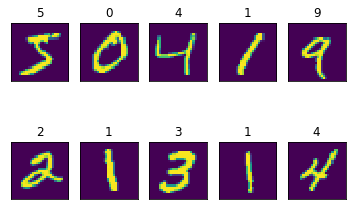

In [6]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.figure()
for i in range(10):  
    plt.subplot(2, 5, i+1)
    plt.title(y_train[i])
    f = plt.imshow(x_train[i])
    f.axes.get_xaxis().set_visible(False)
    f.axes.get_yaxis().set_visible(False)
plt.show()

## Adecuación/preparación de los datos

Las imágenes están compuestas por números enteros que representan una escala de grises (`0`: blanco, `255`:negro). El rango real `[0,1]` es mucho más adecuado, por lo que normalizamos los datos:

In [7]:
print(x_train.min(),x_train.max(),x_test.min(),x_test.max())
x_train = x_train / 255
x_test = x_test / 255
print(x_train.min(),x_train.max(),x_test.min(),x_test.max())

0 255 0 255
0.0 1.0 0.0 1.0


Reparticionaremos el conjunto de entrenamiento, reservando el 10% de los datos para validación (monitorización del entrenamiento):

In [8]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state=42)

Agruparemos todos los datos en una única variable

In [9]:
from collections import namedtuple

Data = namedtuple('Data', 'input_shape output_categories x_train y_train x_val y_val x_test y_test')
data = Data(x_train.shape[1:], y_train.max()+1, 
            x_train, y_train, 
            x_val, y_val, 
            x_test, y_test)

for name,value in zip(data._fields, data) :
    if name == 'input_shape' or name == 'output_categories':
        print(name,'=',value)
    else :
        print(name,value.shape)

input_shape = (28, 28)
output_categories = 10
x_train (54000, 28, 28)
y_train (54000,)
x_val (6000, 28, 28)
y_val (6000,)
x_test (10000, 28, 28)
y_test (10000,)


## Primer modelo: Regresión Logística Multiclase

Uno de los modelos más sencillos a implementar es una regresión logística multiclase.

<!--
![alt text](img/lr.jpg)
-->

<img src="img/lr.jpg" alt="Global Average Pooling" style="width: 400px;"/>


El modelo se compone de:

   1. `Flatten` : Conversión de las matrices $M$ de entrada de `28x28` en vectores $x$ de `784` componentes.
   1. `Dense` :  Transformación afín $y = A \cdot x + b$ con activación _softmax_ :
   
       &emsp;&emsp;&emsp;&emsp;$z_i = exp(y_i)/\sum_{j}^{ }exp(y_j))$
   


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

def LR(data):
    
    model = Sequential()
    
    model.add(Flatten(input_shape=data.input_shape))
    
    model.add(Dense(data.output_categories, activation='softmax'))
    
    return model

In [11]:
model = LR(data)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


La función de pérdida (`loss`) será la [entropía cruzada](https://es.wikipedia.org/wiki/Entrop%C3%ADa_cruzada), y el optimizados escogido adam ([Adaptive Moment Estimation](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam)). Estamos además interesados en observar el índice de acierto, o _accuracy_ :

In [12]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Ejecutaremos 5 iteraciones de entrenamiento, observando la evolución de los conjuntos de entrenamiento y validación:


In [13]:
train = model.fit(data.x_train, data.y_train, epochs=5, validation_data = (data.x_val, data.y_val), verbose = 2)

Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 - 6s - loss: 0.4861 - accuracy: 0.8737 - val_loss: 0.3211 - val_accuracy: 0.9115
Epoch 2/5
54000/54000 - 5s - loss: 0.3097 - accuracy: 0.9143 - val_loss: 0.2874 - val_accuracy: 0.9208
Epoch 3/5
54000/54000 - 5s - loss: 0.2878 - accuracy: 0.9192 - val_loss: 0.2756 - val_accuracy: 0.9220
Epoch 4/5
54000/54000 - 5s - loss: 0.2766 - accuracy: 0.9226 - val_loss: 0.2727 - val_accuracy: 0.9258
Epoch 5/5
54000/54000 - 6s - loss: 0.2690 - accuracy: 0.9248 - val_loss: 0.2686 - val_accuracy: 0.9245


La variable `train` almacena (entre otras cosas) el historial de la función de coste (`loss`) y la métrica usada (`accuracy`):

In [14]:
print(train.history['loss'])
print(train.history['val_loss'])
print(train.history['accuracy'])
print(train.history['val_accuracy'])

[0.4860796339335265, 0.30970703077316286, 0.2878235067802447, 0.2766274855600463, 0.26902652798537857]
[0.3210533874432246, 0.2874434420665105, 0.275649048268795, 0.27269759770234425, 0.26860900764664014]
[0.8736852, 0.9143148, 0.91918516, 0.92255557, 0.9247963]
[0.9115, 0.92083335, 0.922, 0.92583334, 0.9245]


Finalmente observamos el resultado frente al conjunto de test:

In [15]:
test = model.evaluate(data.x_test, data.y_test, verbose=0)
print(f'loss: {test[0]:.4f} acc: {test[1]:.4f}')

loss: 0.2694 acc: 0.9252


Podemos representar gráficamente además la evolución de la función objetivo de entrenamiento y validación.

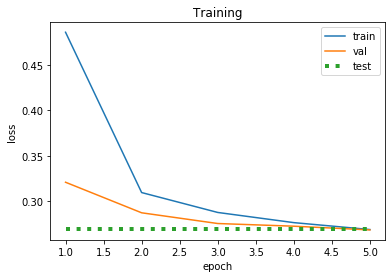

In [16]:
from matplotlib.ticker import MaxNLocator

def plot(train,test):
    n = len(train.history['loss'])
    x = list(range(1,n+1))
    fig = plt.figure()
    plt.plot(x,train.history['loss'])
    plt.plot(x,train.history['val_loss'])
    plt.plot(x,[test[0]]*n,linestyle=':', linewidth=4)
    plt.title('Training')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val', 'test'], loc='upper right')
    plt.show()
    
plot(train,test)

En base al código anterior, creamos una función que permita simplificar la evaluación de distintos modelos:

In [17]:
import numpy as np
import tensorflow.keras.backend as K

def evaluate(model, data, optimizer='adam', epochs=10):
    
    model.compile(optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

    if len(model.layers) <= 15 :
        model.summary()
    else :
        print(f'Skipping model Summary... it has {len(model.layers)} Layers!')
        tr = np.sum([K.count_params(w) for w in model.trainable_weights])
        ntr = np.sum([K.count_params(w) for w in model.non_trainable_weights])
        print(f'Total params: {tr+ntr}')
        print(f'Trainable params: {tr}')
        print(f'Non-trainable params: {ntr}')       
    
    print('\n----- Train -----')
    train = model.fit(data.x_train, data.y_train,
                        epochs=epochs, validation_data = (data.x_val, data.y_val),
                        verbose = 2)
    print('\n----- Test ------')
    test = model.evaluate(data.x_test,  data.y_test, verbose=0)
    print(f'loss: {test[0]:.4f} acc: {test[1]:.4f}')
    
    plot(train,test)

La evaluación de un modelo LR será:

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________

----- Train -----
Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 - 6s - loss: 0.4864 - accuracy: 0.8717 - val_loss: 0.3224 - val_accuracy: 0.9105
Epoch 2/10
54000/54000 - 7s - loss: 0.3098 - accuracy: 0.9127 - val_loss: 0.2905 - val_accuracy: 0.9170
Epoch 3/10
54000/54000 - 5s - loss: 0.2878 - accuracy: 0.9197 - val_loss: 0.2781 - val_accuracy: 0.9210
Epoch 4/10
54000/54000 - 6s - loss: 0.2765 - accuracy: 0.9230 - val_loss: 0.2732 - val_accuracy: 0.9240
Epoch 5/10
54000/54000 - 7s - 

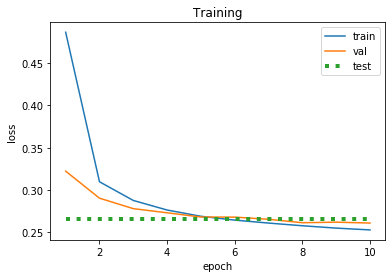

In [18]:
model = LR(data)
evaluate(model, data)

## Red neuronal con una capa oculta

![alt text](img/nn.png)

Podemos añadir una capa oculta del tamaño que deseemos...

In [19]:
def NN(data, hidden, activation='relu'):

    model = Sequential()
    
    model.add(Flatten(input_shape=data.input_shape))
    
    model.add(Dense(hidden, activation=activation))

    model.add(Dense(data.output_categories, activation='softmax'))
    
    return model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________

----- Train -----
Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 - 7s - loss: 0.2865 - accuracy: 0.9188 - val_loss: 0.1619 - val_accuracy: 0.9530
Epoch 2/10
54000/54000 - 6s - loss: 0.1308 - accuracy: 0.9621 - val_loss: 0.1141 - val_accuracy: 0.9670
Epoch 3/10
54000/54000 - 6s - loss: 0.0916 - accuracy: 0.9731 - val_loss: 0.1128 - val_accuracy: 0.9650


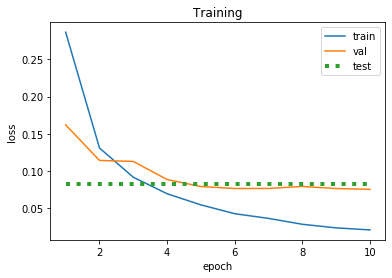

In [20]:
evaluate(NN(data, hidden=100), data)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 200)               157000    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                2010      
Total params: 159,010
Trainable params: 159,010
Non-trainable params: 0
_________________________________________________________________

----- Train -----
Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 - 8s - loss: 0.2486 - accuracy: 0.9284 - val_loss: 0.1319 - val_accuracy: 0.9617
Epoch 2/10
54000/54000 - 6s - loss: 0.1066 - accuracy: 0.9681 - val_loss: 0.0932 - val_accuracy: 0.9728
Epoch 3/10
54000/54000 - 6s - loss: 0.0705 - accuracy: 0.9788 - val_loss: 0.0894 - val_accuracy: 0.973

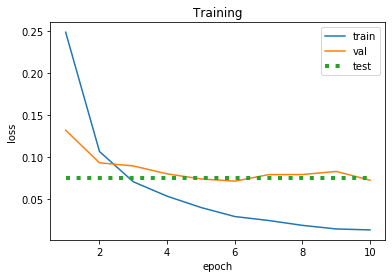

In [21]:
evaluate(NN(data, hidden=200), data)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_7 (Dense)              (None, 10)                3010      
Total params: 238,510
Trainable params: 238,510
Non-trainable params: 0
_________________________________________________________________

----- Train -----
Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 - 6s - loss: 0.2302 - accuracy: 0.9334 - val_loss: 0.1104 - val_accuracy: 0.9682
Epoch 2/10
54000/54000 - 6s - loss: 0.0949 - accuracy: 0.9711 - val_loss: 0.0864 - val_accuracy: 0.9758
Epoch 3/10
54000/54000 - 5s - loss: 0.0647 - accuracy: 0.9808 - val_loss: 0.0743 - val_accuracy: 0.978

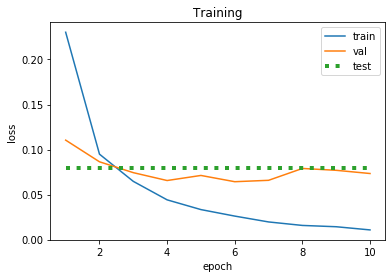

In [22]:
evaluate(NN(data, hidden=300), data)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1000)              785000    
_________________________________________________________________
dense_9 (Dense)              (None, 10)                10010     
Total params: 795,010
Trainable params: 795,010
Non-trainable params: 0
_________________________________________________________________

----- Train -----
Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 - 6s - loss: 0.1937 - accuracy: 0.9419 - val_loss: 0.0998 - val_accuracy: 0.9717
Epoch 2/10
54000/54000 - 5s - loss: 0.0778 - accuracy: 0.9761 - val_loss: 0.0800 - val_accuracy: 0.9760
Epoch 3/10
54000/54000 - 7s - loss: 0.0515 - accuracy: 0.9842 - val_loss: 0.0839 - val_accuracy: 0.977

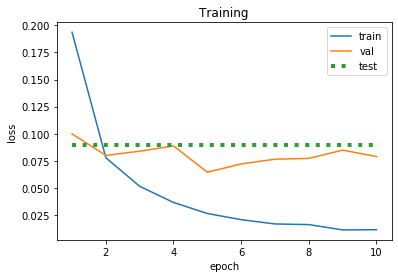

In [23]:
evaluate(NN(data, hidden=1000), data)

## DNN - Deep Neural Network

![alt text](img/dnn.png)

Una DNN no es sino una NN conpuesta por múltiples capas ocultas. Podemos añadir tantas capas densas como deseemos...


In [24]:
def DNN(data, hidden=(), activation='relu'):

    model = Sequential()
    
    model.add(Flatten(input_shape=data.input_shape))

    for h in hidden :
        model.add(Dense(h, activation=activation))
        
    model.add(Dense(data.output_categories, activation='softmax'))
    
    return model

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_11 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_12 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_13 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_14 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_15 (Dense)             (None, 10)               

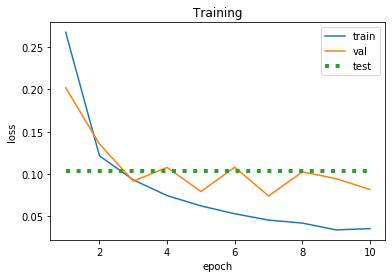

In [25]:
model = DNN(data, hidden=(100,100,100,100,100))
evaluate(model, data)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1024)              803840    
_________________________________________________________________
dense_17 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_18 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_19 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_20 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_21 (Dense)             (None, 10)               

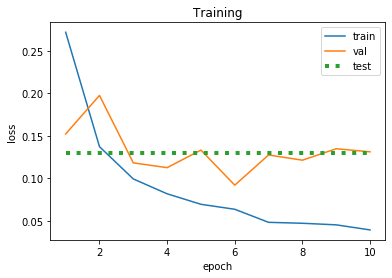

In [26]:
model = DNN(data, hidden=(1024,1024,1024,1024,1024))
evaluate(model, data)

## Dropout - Evitando el sobreentrenamiento

Se trata de una sencilla y (a veces) efectiva regularización que desconecta aleatoriamente las neuronas durante el entrenamiento.


<!--
![alt text](img/dropout.png)
-->

<img src="img/dropout.png" alt="Global Average Pooling" style="width: 600px;"/>

In [27]:
from tensorflow.keras.layers import Dropout
    
def DNN(data, hidden=(), activation='relu', dropout=0.2):

    model = Sequential()
    
    model.add(Flatten(input_shape=data.input_shape))

    for h in hidden :
        model.add(Dense(h, activation=activation))
        if dropout :
            model.add(Dropout(dropout))
        
    model.add(Dense(data.output_categories, activation='softmax'))
    
    return model

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 1024)              803840    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)             

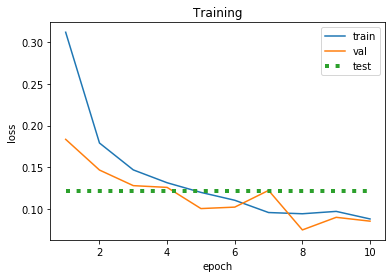

In [28]:
model = DNN(data, hidden=(1024,1024,1024,1024,1024))
evaluate(model, data)

No obstante, a menudo un modelo con menor número de parámetros puede tener un comportamiento más que aceptable

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 128)               100480    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)               

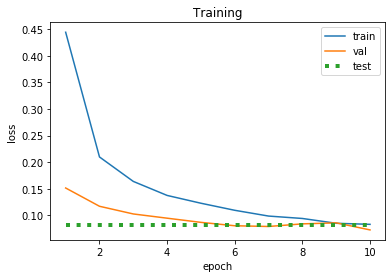

In [29]:
model = DNN(data, hidden=(128,64,32))
evaluate(model, data)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 300)               235500    
_________________________________________________________________
dropout_8 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 10)                3010      
Total params: 238,510
Trainable params: 238,510
Non-trainable params: 0
_________________________________________________________________

----- Train -----
Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 - 8s - loss: 0.2525 - accuracy: 0.9265 - val_loss: 0.1181 - val_accuracy: 0.9628
Epoch 2/10
54000/54000 - 7s - loss: 0.1153 - accuracy: 0.9650 - val_loss:

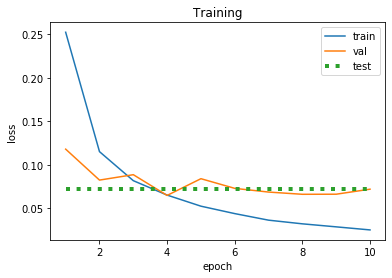

In [30]:
model = DNN(data, hidden=(300,))
evaluate(model, data)

## Redes Convolucionales

Una capa convolucional aplica un conjunto de kernels (filtros) que son convolucionados frente a la entrada. El resultado es un `3D-array`. 

![alt text](img/cnn.png)

Para poder usar las capas convolutivas, hay que agregar una dimensión más a los datos.

In [31]:
# Agrega una dimension de canal
data_conv = Data(
    data.input_shape+(1,), data.output_categories,
    data.x_train[..., tf.newaxis], data.y_train,
    data.x_val[..., tf.newaxis], data.y_val,
    data.x_test[..., tf.newaxis], data.y_test
)
for name,value in zip(data_conv._fields, data_conv) :
    if name == 'input_shape' or name == 'output_categories':
        print(name,'=',value)
    else :
        print(name,value.shape)

input_shape = (28, 28, 1)
output_categories = 10
x_train (54000, 28, 28, 1)
y_train (54000,)
x_val (6000, 28, 28, 1)
y_val (6000,)
x_test (10000, 28, 28, 1)
y_test (10000,)


In [32]:
from tensorflow.keras.layers import Conv2D, MaxPool2D

def CNN(data, activation='relu'):
    
    model = Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation=activation, input_shape=data.input_shape))
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation=activation))
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation=activation))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(data.output_categories, activation='softmax'))
    
    return model

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 576)             

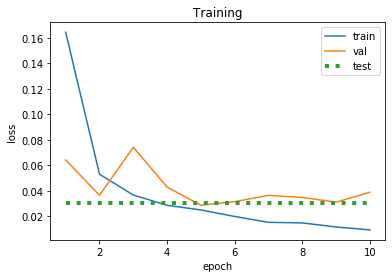

In [33]:
model = CNN(data_conv)
evaluate(model, data_conv)

## Pero... y el _dropout_ ?

* [Don’t Use Dropout in Convolutional Networks](https://www.kdnuggets.com/2018/09/dropout-convolutional-networks.html), use BatchNormalization instead.
   * Parece ser que la regularización mediante _dropout_ no es muy adecuada para las CNN
* `BatchNormalization`: Normaliza (**solo** durante el entrenamiento) la media y varianza de los datos de entrada (por batch).

La normalización suele ser aplicada antes de la función de activación, por lo que hay que separar a esta última de la capa de convolución.

In [34]:
from tensorflow.keras.layers import Activation, BatchNormalization

def CNNbnorm(data, activation='relu'):
    
    model = Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', input_shape=data.input_shape))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Conv2D(filters=32, kernel_size=3, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Conv2D(filters=64, kernel_size=3, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(data.output_categories, activation='softmax'))
    
    return model

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 32)      

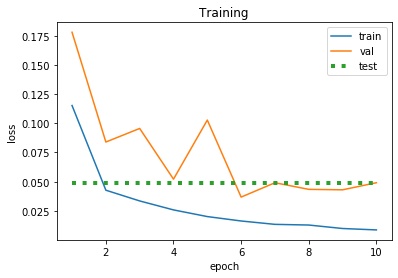

In [35]:
model = CNNbnorm(data_conv)
evaluate(model, data_conv)

Personalmente... sigue pareciéndome más efectivo el dropout...

In [36]:
from tensorflow.keras.layers import Conv2D

def CNNdropout(data, activation='relu', dropout=0.2):
    
    model = Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation=activation, input_shape=data.input_shape))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(dropout))
    
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation=activation))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(dropout))
    
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation=activation))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(dropout))

    model.add(Flatten())
    model.add(Dense(data.output_categories, activation='softmax'))
    
    return model

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 64)        

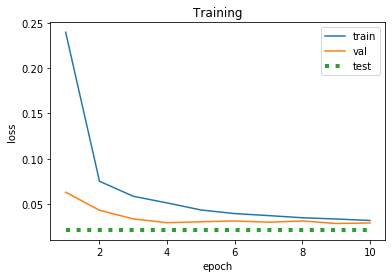

In [37]:
model = CNNdropout(data_conv)
evaluate(model, data_conv)

## Global-average-pooling

Las redes convolucioinales deben terminar en una capa densa con activación _softmax_. La última capa densa debe conectarse a otra capa densa, que normalmente será el resultado de aplanar (`Flatten`) la última capa convolucional. La capa `GlobalAveragePooling2D` realiza un promedio de los canales de la capa convolucional anterior, resultando en un vector cuya dimensión es igual al número de canales. El resultado es una reducción sustancial en el número de parámetros del modelo. 


<!--
![alt text](img/gap.png)
-->

<img src="img/gap.png" alt="Global Average Pooling" style="width: 1200px;"/>

* https://adventuresinmachinelearning.com/global-average-pooling-convolutional-neural-networks/


 

In [38]:
from tensorflow.keras.layers import GlobalAveragePooling2D

def CNNgap(data, activation='relu',dropout=0.2):
    
    model = Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation=activation, input_shape=data.input_shape))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(dropout))
    
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation=activation))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(dropout))
    
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation=activation))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(dropout))
        
    model.add(GlobalAveragePooling2D())
    model.add(Dense(data.output_categories, activation='softmax'))
    
    return model

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 7, 64)        

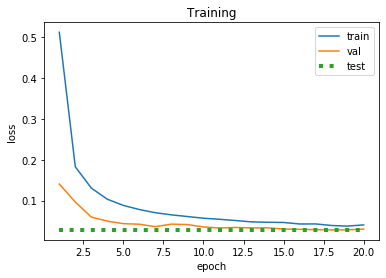

In [39]:
model = CNNgap(data_conv)
evaluate(model, data_conv, epochs=20)

## Reproduciendo resultados ajenos

* https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6
* https://www.kaggle.com/adityaecdrid/mnist-with-keras-for-beginners-99457

Primero el modelo:

In [40]:
from tensorflow.keras.optimizers import RMSprop

def XModel(data):

    model = Sequential()

    model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', activation ='relu', input_shape=data.input_shape))
    model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(0.3))
    model.add(Dense(data.output_categories, activation='softmax'))
    
    return model

A menudo el parámetro _learning-rate_ suele ser modificado _online_ para adaptarse al entrenamiento. Una estrategia sencilla es reducirlo si la función objetivo no decrece:

In [41]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

#reduce the LR by half if the training loss is not improved after 1 epochs.
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', 
                                            patience=1, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-10)

Añadimos la reducción del learning-rate a los _callbacks_ del entrenamiento: 

In [42]:
def evaluate(model, data, optimizer='adam', epochs=10):
    
    model.compile(optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

    if len(model.layers) <= 15 :
        model.summary()
    else :
        print(f'Skipping model Summary... it has {len(model.layers)} Layers!')
        tr = np.sum([K.count_params(w) for w in model.trainable_weights])
        ntr = np.sum([K.count_params(w) for w in model.non_trainable_weights])
        print(f'Total params: {tr+ntr}')
        print(f'Trainable params: {tr}')
        print(f'Non-trainable params: {ntr}')        
    
    print('\n----- Train -----')
    train = model.fit(data.x_train, data.y_train,
                        epochs=epochs, validation_data = (data.x_val, data.y_val),
                        verbose = 2, callbacks=[learning_rate_reduction])
    print('\n----- Test ------')
    test = model.evaluate(data.x_test,  data.y_test, verbose=0)
    print(f'loss: {test[0]:.4f} acc: {test[1]:.4f}')
    
    plot(train,test)

Evaluamos el modelo, usando un optimizador _RMSprop_ en vez de _Adam_ (por defecto):

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 7, 7, 64)        

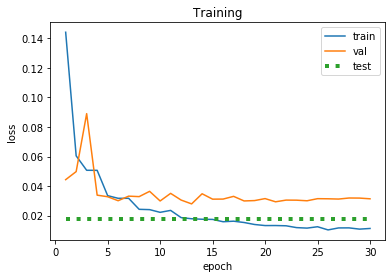

In [43]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model = XModel(data_conv)
evaluate(model, data_conv, optimizer=optimizer, epochs=30)

## La Red Residual (Residual Network, ResNet)

 * http://personal.cimat.mx:8181/~mrivera/cursos/aprendizaje_profundo/resnet/resnet.html
 * https://en.wikipedia.org/wiki/Residual_neural_network

Una Red Residual o _ResNet_ contiene conexiones ( _skip connections_ o _shortcuts_ ) que interconectan la salida de una capa con la entrada de una capa no necesariamente contigua, saltando capas intermedias:

<img src="img/ResNet.png" alt="Residual Network" style="width: 200px;"/>

De una manera conceptual, en la fase inicial del entrenamiento la red es guiada por las conexiones cortocircuito, mientras que según avanza el entrenamiento las capas cortocircuitadas comienzan a aportar, compensando a su vez la aportación del cortocircuito.

### Características:

   * Mitiga el problema del _desvanecimiento de gradiente_
   * Acelera el entrenamiento
   * Permite entrenar redes muy profundas (más de 100 capas)

### ResNet identidad

Configuración típica:

   * Capas convolucionales
   * Puente de 2/3 capas
   * El cortocircuito se añade antes de la no linealidad

<img src="img/resnet_identidad.png" alt="resnet identidad" style="width: 400px;"/>

### ResNet convolucional

Configuración típica:

   * Capas convolucionales
   * Puente de 2/3 capas
   * El cortocircuito se añade antes de la no linealidad
   * Las dimensiones no coinciden.
      * Se añade una capa convolucional al cortocircuito
      * No se añade no linealidad

<img src="img/resnet_conv.png" alt="resnet_conv" style="width: 400px;"/>


### RestNet50
<img src="img/resnet50.png" alt="resnet50" style="width: 800px;"/>

### ImageNet Challenge

* Detección de 1000 categorías de objetos en imágenes

|    Red    |  Año | Capas | % Error |
|:---------:|:----:|:-----:|:-------:|
|  AlexNet  | 2013 |   8   |   11.7  |
|    VGG    | 2014 |   19  |   7.3   |
| Inception | 2014 |   22  |   6.7   |
|   ResNet  | 2015 |  152  |   3.6   |


### Implementación de una RestNet
* No es una red secuencial
* No podemos implementarla mediante `tensorflow.keras.models.Sequential`
* TensorFlow permite una descripción *funcional* del modelo
    * Muy similar a lo visto previamente
    * Mayor livertad de diseño

### Logistic Regression - Functional API

Implementación previa (`Sequential`):

```python
def LR(data):    
    model = Sequential()  
    model.add(Flatten(input_shape=data.input_shape))
    model.add(Dense(data.output_categories, activation='softmax'))
    return model
```

Implementación funcional:

In [44]:
from tensorflow.keras import Input, Model

def LR(data):

    x_input = Input(shape=data.input_shape)

    x = Flatten()(x_input)
    x = Dense(data.output_categories, activation='softmax')(x)
    
    return Model(x_input, x)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________

----- Train -----
Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 - 5s - loss: 0.4883 - accuracy: 0.8735 - val_loss: 0.3218 - val_accuracy: 0.9142
Epoch 2/10
54000/54000 - 5s - loss: 0.3102 - accuracy: 0.9139 - val_loss: 0.2885 - val_accuracy: 0.9210
Epoch 3/10
54000/54000 - 5s - loss: 0.2881 - accuracy: 0.9191 - val_loss: 0.2767 - val_accuracy: 0.9237
Epoch 4/1

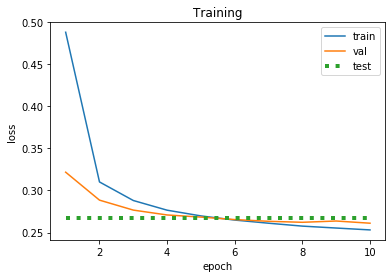

In [45]:
model = LR(data)
evaluate(model, data, epochs=10)

### DNN - Functional API

Implementación previa (`Sequential`):

```python
def DNN(data, hidden=(), activation='relu', dropout=0.2):
    model = Sequential()
    model.add(Flatten(input_shape=data.input_shape))
    for h in hidden :
        model.add(Dense(h, activation=activation))
        if dropout :
            model.add(Dropout(dropout))
    model.add(Dense(data.output_categories, activation='softmax'))
    return model
```

Implementación funcional:

In [46]:
from tensorflow.keras.layers import Dropout
    
def DNN(data, hidden=(), activation='relu', dropout=0.2):

    x_input = Input(shape=data.input_shape)

    x = Flatten()(x_input)
    for h in hidden :
        x = Dense(h, activation=activation)(x)
        if dropout :
            x = Dropout(dropout)(x)
    x = Dense(data.output_categories, activation='softmax')(x)
    
    return Model(x_input, x)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 128)               100480    
_________________________________________________________________
dropout_18 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_19 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 32)                2080

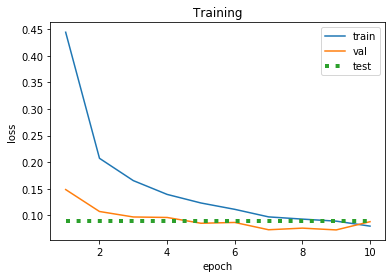

In [47]:
model = DNN(data, hidden=(128,64,32))
evaluate(model, data)

### CNN - Functional API

Implementación previa (`Sequential`):

```python
def CNN(data, activation='relu',dropout=0.2):
    
    model = Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation=activation, input_shape=data.input_shape))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(dropout))
    
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation=activation))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(dropout))
    
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation=activation))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(dropout))
        
    model.add(GlobalAveragePooling2D())
    model.add(Dense(data.output_categories, activation='softmax'))
    
    return model
```

Implementación funcional:

In [48]:
def CNN(data, activation='relu',dropout=0.2):
    
    x_input = Input(shape=data.input_shape)

    x = Conv2D(filters=32, kernel_size=3, padding='same', activation=activation)(x_input)
    x = MaxPool2D(pool_size=(2,2))(x)
    x = Dropout(dropout)(x)
    
    x = Conv2D(filters=32, kernel_size=3, padding='same', activation=activation)(x)
    x = MaxPool2D(pool_size=(2,2))(x)
    x = Dropout(dropout)(x)
    
    x = Conv2D(filters=64, kernel_size=3, padding='same', activation=activation)(x)
    x = MaxPool2D(pool_size=(2,2))(x)
    x = Dropout(dropout)(x)
        
    x = GlobalAveragePooling2D()(x)
    x = Dense(data.output_categories, activation='softmax')(x)
    
    return Model(x_input, x)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 7, 7, 64)        

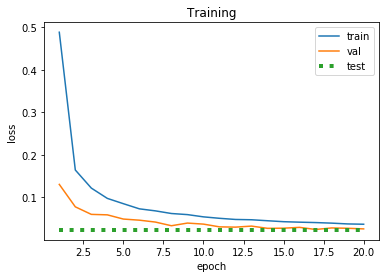

In [49]:
model = CNNgap(data_conv)
evaluate(model, data_conv, epochs=20)

### RestNet - Functional API (no hay otra...)


In [50]:
from tensorflow.keras.layers import Add

def ResNet(data,n=1):

    x_input = Input(shape=data.input_shape)
    
    x = Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same')(x_input)
    x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)

    for i in range(n):
        x_id = x
        x = Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same')(x_input)
        x = BatchNormalization()(x)
        x = Activation(activation='relu')(x)
        x = Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same')(x)
        x = BatchNormalization()(x)
        x = Add()([x, x_id])
        x = Activation(activation='relu')(x)
    x = MaxPool2D(pool_size=(2,2))(x)
    
    x = Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same')(x)
    x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)

    for i in range(n):
        x_id = x
        x = Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same')(x)
        x = BatchNormalization()(x)
        x = Activation(activation='relu')(x)
        x = Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same')(x)
        x = BatchNormalization()(x)
        x = Add()([x, x_id])
        x = Activation(activation='relu')(x)
    x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

    x = GlobalAveragePooling2D()(x)
    
    x = Dense(data.output_categories, activation = "softmax")(x)    

    return Model(x_input, x)

Skipping model Summary... it has 25 Layers!
Total params: 121450
Trainable params: 120874
Non-trainable params: 576

----- Train -----
Train on 54000 samples, validate on 6000 samples
Epoch 1/20
54000/54000 - 16s - loss: 0.1649 - accuracy: 0.9615 - val_loss: 11.5962 - val_accuracy: 0.1472
Epoch 2/20
54000/54000 - 17s - loss: 0.0501 - accuracy: 0.9861 - val_loss: 5.2290 - val_accuracy: 0.3297
Epoch 3/20
54000/54000 - 18s - loss: 0.0376 - accuracy: 0.9886 - val_loss: 4.9166 - val_accuracy: 0.3485
Epoch 4/20
54000/54000 - 17s - loss: 0.0325 - accuracy: 0.9900 - val_loss: 6.2439 - val_accuracy: 0.3212
Epoch 5/20
54000/54000 - 18s - loss: 0.0271 - accuracy: 0.9916 - val_loss: 1.6991 - val_accuracy: 0.6115
Epoch 6/20
54000/54000 - 17s - loss: 0.0239 - accuracy: 0.9926 - val_loss: 2.4312 - val_accuracy: 0.5857
Epoch 7/20
54000/54000 - 14s - loss: 0.0204 - accuracy: 0.9935 - val_loss: 1.0743 - val_accuracy: 0.6698
Epoch 8/20
54000/54000 - 17s - loss: 0.0181 - accuracy: 0.9947 - val_loss: 1.491

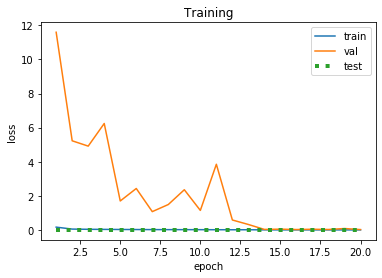

In [51]:
model = ResNet(data_conv)
#model.summary()
evaluate(model, data_conv, epochs=20)

Skipping model Summary... it has 151 Layers!
Total params: 1031242
Trainable params: 1027210
Non-trainable params: 4032

----- Train -----
Train on 54000 samples, validate on 6000 samples
Epoch 1/30
54000/54000 - 79s - loss: 0.1201 - accuracy: 0.9653 - val_loss: 0.9386 - val_accuracy: 0.6955
Epoch 2/30
54000/54000 - 70s - loss: 0.0521 - accuracy: 0.9839 - val_loss: 4.8157 - val_accuracy: 0.2950
Epoch 3/30
54000/54000 - 71s - loss: 0.0434 - accuracy: 0.9869 - val_loss: 1.3138 - val_accuracy: 0.6125
Epoch 4/30
54000/54000 - 70s - loss: 0.0374 - accuracy: 0.9889 - val_loss: 0.0729 - val_accuracy: 0.9812
Epoch 5/30
54000/54000 - 70s - loss: 0.0328 - accuracy: 0.9896 - val_loss: 0.1169 - val_accuracy: 0.9625
Epoch 6/30
54000/54000 - 70s - loss: 0.0262 - accuracy: 0.9919 - val_loss: 0.2964 - val_accuracy: 0.9248
Epoch 7/30
54000/54000 - 68s - loss: 0.0247 - accuracy: 0.9925 - val_loss: 0.0976 - val_accuracy: 0.9710
Epoch 8/30
54000/54000 - 70s - loss: 0.0221 - accuracy: 0.9929 - val_loss: 0.

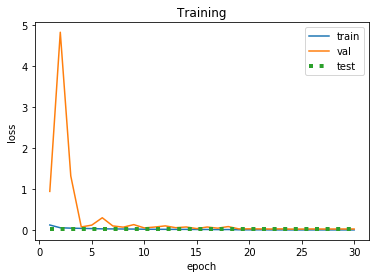

In [52]:
model = ResNet(data_conv,n=10)
evaluate(model, data_conv, epochs=30)

In [53]:
def ResNet2(data):
    
    x_input = Input(shape=data.input_shape)
    
    x = Conv2D(32, 3, activation='relu')(x_input)
    x = Conv2D(64, 3, activation='relu')(x)
    block_1_output = MaxPool2D(3)(x)

    x = Conv2D(64, 3, activation='relu', padding='same')(block_1_output)
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    block_2_output = Add()([x, block_1_output])

    x = Conv2D(64, 3, activation='relu', padding='same')(block_2_output)
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    block_3_output = Add()([x, block_2_output])

    x = Conv2D(64, 3, activation='relu')(block_3_output)
    x = GlobalAveragePooling2D()(x)
    
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)    
    x = Dense(data.output_categories, activation = "softmax")(x)    

    return Model(x_input, x)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_67 (Conv2D)              (None, 26, 26, 32)   320         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_68 (Conv2D)              (None, 24, 24, 64)   18496       conv2d_67[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_21 (MaxPooling2D) (None, 8, 8, 64)     0           conv2d_68[0][0]                  
____________________________________________________________________________________________

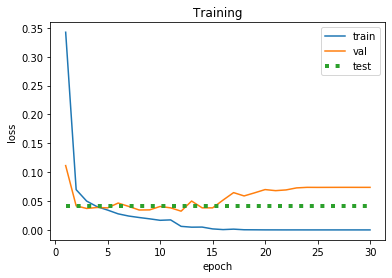

In [54]:
model = ResNet2(data_conv)
evaluate(model, data_conv, epochs=30)